<a href="https://colab.research.google.com/github/Ishi-ka117/image_denoising_/blob/main/IMAGE_DENOISING_USING_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
LIBRARIES

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import train_test_split
import cv2
import glob
import matplotlib.pyplot as plt


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


LOADING IMAGES, RESIZING, SPLITTING

In [5]:
def load_images(image_dir, image_size):
    images = []
    for img_path in glob.glob(os.path.join(image_dir, '*.png')):
        img = cv2.imread(img_path)
        img = cv2.resize(img, image_size)
        img = img / 255.0
        images.append(img)
    return np.array(images)

image_size = (128, 128)
low_res_images_path = '/content/drive/MyDrive/Train/Train/low'
high_res_images_path = '/content/drive/MyDrive/Train/Train/high'

low_res_images = load_images(low_res_images_path, image_size)
high_res_images = load_images(high_res_images_path, image_size)

low_res_train, low_res_val, high_res_train, high_res_val = train_test_split(
    low_res_images, high_res_images, test_size=0.4,train_size=0.6, random_state=42)

low_res_test=low_res_val

ADDING NOISE TO THE IMAGES

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def add_noise(images, noise_factor=0.1):
    noisy_images = images + noise_factor * np.random.randn(*images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images
noisy_low_res_train = add_noise(low_res_train)
noisy_low_res_val = add_noise(low_res_val)


IMPLEMENTING CONVOLUTIONAL NEURAL NETWORK
COMPILING THE MODEL

In [8]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='mean_squared_error')


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 256)       0

DEFINIGN EPOCHS AND OPTIMIZER

In [18]:
image_size = (128, 128)
batch_size = 64
epochs = 50
learning_rate = 1e-5

IMPLEMENTING DATA AUGMENTATION

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

augmented_images = datagen.flow(noisy_low_res_train, high_res_train, batch_size=batch_size)

In [20]:
# Train the model using the augmented images
model.fit(augmented_images,
          epochs=epochs,
          steps_per_epoch=len(noisy_low_res_train) // batch_size,
          validation_data=(noisy_low_res_val, high_res_val))

Epoch 1/50
4/4 [==============================] - 196s 57s/step - loss: 0.0476 - val_loss: 0.0489
Epoch 2/50
4/4 [==============================] - 203s 54s/step - loss: 0.0488 - val_loss: 0.0490
Epoch 3/50
4/4 [==============================] - 184s 47s/step - loss: 0.0483 - val_loss: 0.0492
Epoch 4/50
4/4 [==============================] - 213s 57s/step - loss: 0.0483 - val_loss: 0.0493
Epoch 5/50
4/4 [==============================] - 186s 55s/step - loss: 0.0479 - val_loss: 0.0495
Epoch 6/50
4/4 [==============================] - 188s 48s/step - loss: 0.0484 - val_loss: 0.0496
Epoch 7/50
4/4 [==============================] - 200s 59s/step - loss: 0.0479 - val_loss: 0.0496
Epoch 8/50
4/4 [==============================] - 198s 51s/step - loss: 0.0474 - val_loss: 0.0494
Epoch 9/50
4/4 [==============================] - 190s 49s/step - loss: 0.0487 - val_loss: 0.0493
Epoch 10/50
4/4 [==============================] - 192s 55s/step - loss: 0.0472 - val_loss: 0.0493
Epoch 11/50
4/4 [==

EVALUATING THE MODEL

In [21]:

decoded_imgs = model.predict(noisy_low_res_val)


7/7 [==============================] - 56s 8s/step


In [22]:
 from sklearn.metrics import mean_squared_error, mean_absolute_error
 from math import log10, sqrt
 def PSNR(original, reconstructed):
        mse = mean_squared_error(original.flatten(), reconstructed.flatten())
        if mse == 0:  # MSE is zero means no noise is present in the signal.
            return 100
        max_pixel = 1.0  # Since the images are normalized between 0 and 1
        psnr = 20 * log10(max_pixel / sqrt(mse))
        return psnr

In [23]:
mse_val = mean_squared_error(high_res_val.flatten(), decoded_imgs.flatten())
psnr_val = PSNR(high_res_val, decoded_imgs)
mae_val = mean_absolute_error(high_res_val.flatten(), decoded_imgs.flatten())



In [24]:
mse_val

0.04697833950530006

In [25]:
psnr_val

13.281023378442798

In [26]:
mae_val

0.1789042852058105

SAVING THE PREDICTED IMAGES

In [28]:
factor = 1  # Define factor with a specific value (replace 1 with your desired value)
output_dir = f'./test/predicted_{factor}/'
os.makedirs(output_dir, exist_ok=True)

for i, img in enumerate(decoded_imgs):
    cv2.imwrite(os.path.join(output_dir, f'predicted_{i}.png'), cv2.cvtColor(img * 255, cv2.COLOR_RGB2BGR))


PLOT THE PREDICTED IMAGES

In [29]:
predicted_files = os.listdir(output_dir)
num_images_to_display = 10

plt.figure(figsize=(20, 4))
for i, file_name in enumerate(predicted_files[:num_images_to_display]):
    img_path = os.path.join(output_dir, file_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

<Figure size 2000x400 with 0 Axes>

DISPLAY THE PREDICTED IMAGE

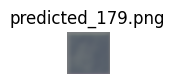

In [30]:
ax = plt.subplot(1, num_images_to_display, i + 1)
plt.imshow(img)
plt.title(file_name)
plt.axis('off')

plt.show()

In [31]:
results[factor] = (mse_val, psnr_val, mae_val)

optimal_factor = max(results, key=lambda x: results[x][1])
print(f"The optimal noise factor is {optimal_factor} with a PSNR of {results[optimal_factor][1]} dB")

NameError: name 'results' is not defined